-1024 1 0 2964


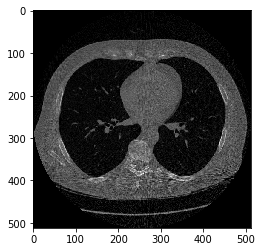

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

# Any results you write to the current directory are saved as output.

import pydicom
import scipy.misc
import numpy as np

lung = pydicom.read_file('/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/1.2.826.0.1.3680043.2.656.1.138.139.dcm')

slice = lung.pixel_array
slice[slice == -2000] = 0
print (lung.RescaleIntercept, lung.RescaleSlope, np.min(slice), np.max(slice))

plt.imshow(slice, cmap=plt.cm.gray)


In [4]:
def get_segmented_lungs(im):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    # Convert into a binary image. 
    binary = im < 604
    
    # Remove the blobs connected to the border of the image
    cleared = clear_border(binary)

    # Label the image
    label_image = label(cleared)

    # Keep the labels with 2 largest areas
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0

    # Closure operation with disk of radius 12
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    
    selem = disk(10)
    binary = binary_closing(binary, selem)
    
    # Fill in the small holes inside the lungs
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)

    # Superimpose the mask on the input image
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    
    return im

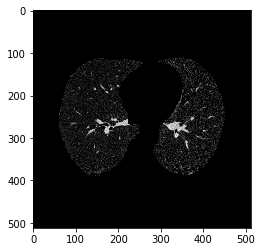

In [5]:


def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [pydicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])


ct_scan = read_ct_scan('/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/') 
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
plt.imshow(segmented_ct_scan[139], cmap=plt.cm.gray)



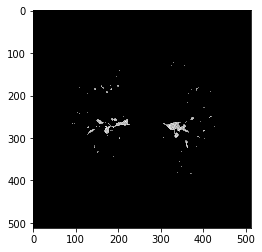

In [6]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
lungs = segmented_ct_scan.copy()
plt.imshow(segmented_ct_scan[139], cmap=plt.cm.gray)


In [7]:
from skimage.morphology import binary_dilation, binary_opening

selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))


In [17]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
print (np.max(segmented_ct_scan))

2371
